<a href="https://colab.research.google.com/github/PiotrGrabysz/GSN/blob/master/%C4%86wiczenie_5_domowe_softmax_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Softmax regression

In this exercise you will train a softmax regression model to recognize handwritten digits.
  
The general setup is as follows:
* we are given a set of pairs $(x, y)$, where $x \in R^D$ is a vector of real numbers representing the features, and $y \in \{1,...,c\}$ is the target (in our case we have ten classes, so $c=10$),
* for a given $x$ we model the probability of $y=j$ by $$h(x)_j=p_j = \frac{e^{w_j^Tx}}{\sum_{i=1}^c e^{w_i^Tx}},$$
* to find the right $w$ we will optimize the so called multiclass log loss:
$$L(y,p) = \log{p_y},$$
$$J(w) = -\frac{1}{n}\sum_{i=1}^n L(y_i,h(x)),$$
* with the loss function in hand we can improve our guesses iteratively:
    * $w_{ij}^{t+1} = w_{ij}^t - \text{step_size} \cdot \frac{\partial J(w)}{\partial w_{ij}}$,
* we can end the process after some predefined number of epochs (or when the changes are no longer meaningful).

Let's start with importing the MNIST dataset.

In [2]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2020-03-26 17:17:10--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.16.155
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.16.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  16.1MB/s    in 0.7s    

2020-03-26 17:17:16 (16.1 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

Let's take a look at the data. In the "x" arrays you'll find the images (encoded as pixel intensities) and in the "y" ones you'll find the labels (one-hot encoded).

In [4]:
print(x_train.shape)
print(y_train.shape)

print(x_train[:10])
print(y_train[:10])

(60000, 784)
(60000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now let us see the data in a more human way.

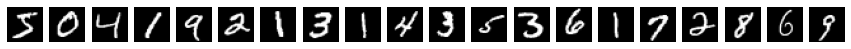

In [5]:
num_samples = 20
samples = range(num_samples)
fig, subplots = plt.subplots(1, num_samples)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(x_train[i, :], [28, 28]), cmap='gray')
    s.axis('off')

Next, we prepare $X$ and $y$ variables

In [6]:
X = x_train[:4000]
y = y_train[:4000]

print(X.shape)
print(y.shape)

(4000, 784)
(4000, 10)


To train the model we will (obviously) use gradient descent. Inside the loop we need a method to compute the gradients. Let's start with implementing it, together with some helper functions.

In [0]:
# We will store the weights in a D x c matrix, where D is the number of features, and c is the number of classes
weights = np.zeros([X.shape[1], 10])

def softmax(z):
    probabilities = np.exp(z)
    partition_function = np.sum(probabilities, axis =  1)
    probabilities = np.transpose(probabilities)/partition_function
    return np.transpose(probabilities) #Transponuję te macierz, żeby miały taki sam wymiar jak macierz y

def predict(weights, X):
    z = np.dot(X, weights)
    return softmax(z)

def compute_loss_and_gradients(weights, X, y, l2_reg, grad = True):
    """Jeśli grad = True, to oblicza też gradient, jeśli grad = False, to zwraca
    pustą listę"""
    p = predict(weights, X)
    n = y.shape[0]
    loss = -1/n*np.sum(y*np.log(p)) + 0.5*l2_reg*np.sum(np.power(weights, 2))
    if grad:
      grad = 1/n*sum([np.outer(X[i,:], p[i,:] - y[i,:]) + l2_reg*weights for i in range(n)])
    else:
      grad = []
    return loss, grad

We are now in position to complete the training pipeline.

If you have problems with convergence, be sure to check the gradients numerically.

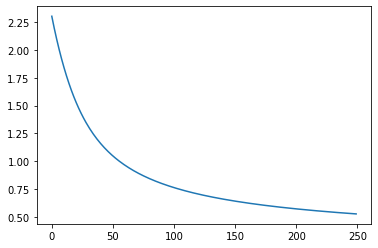

In [8]:
l2_reg = 0.
n_epochs = 250
lr = 0.05

losses = []
for i in range(n_epochs):
    loss, grad = compute_loss_and_gradients(weights, X, y, l2_reg)
    losses.append(loss)
    
    weights -= lr * grad

plt.plot(losses)

Now compute your accuracy on the training and test sets.

In [9]:
preds = predict(weights, X)
preds_training_set = np.argmax(preds, axis = 1)
accuracy_training_set = np.mean(preds_training_set == np.nonzero(y)[1])
print("Training accuracy: {:}".format(accuracy_training_set))

preds = predict(weights, x_test)
preds_test_set = np.argmax(preds, axis = 1)
accuracy_test_set = np.mean(preds_test_set == np.nonzero(y_test)[1])
print("Test accuracy: {:}".format(accuracy_test_set))

Training accuracy: 0.879
Test accuracy: 0.8683


We can also visualize the weights learned by our algorithm. Try to anticipate the result before executing the cell below.

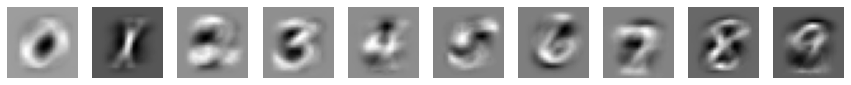

In [10]:
fig, subplots = plt.subplots(1, 10)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(np.array(weights[:, i]), [28, 28]), cmap='gray')
    s.axis('off')

Fun fact - wszystkie wagi sumują się do 0

In [11]:
np.sum(weights)

9.523631883112671e-15

Note that we only used a small portion of the data to develop the model. Now, implement the training on full data. Also, validate your model properly and find a good value for `l2_reg` hyperparameter. Try to experiment with `batch_size`.

Poniżej przygotowuję zbiór walidacyjny. Na podstawie błędu na tym zbiorze będę optymalizować hiperparametry.

In [0]:
permuted_indexes = np.random.permutation(range(x_train.shape[0]))

X = x_train[permuted_indexes[:50000]]
y = y_train[permuted_indexes[:50000]]
x_val = x_train[permuted_indexes[50000:]]
y_val = y_train[permuted_indexes[50000:]]


Poniżej implementacja SGD. Dododałem parametr batch_size.
Dla każdego przebiegu pętli liczę też błąd na zbiorze walidacyjnym.

In [0]:
def SGD(X, y, x_val, y_val, n_epochs = 25, batch_size = 100, l2_reg = 1., lr = 0.05):
  weights = np.zeros([X.shape[1], 10])

  losses = []
  losses_val = []
  
  n_batches = int(X.shape[0]/batch_size)  
  for i in range(n_epochs):
    for j in range(n_batches):
      idx = np.arange(j*batch_size, (j+1)*batch_size)   
      
      loss, grad = compute_loss_and_gradients(weights, X[idx,:], y[idx], l2_reg)
      losses.append(loss)
      loss,_ = compute_loss_and_gradients(weights, x_val, y_val, l2_reg, grad = False)
      losses_val.append(loss)
    
      weights -= lr * grad
  return weights, losses, losses_val


W poniższych komórkach wywołuję SGD dla różnych wartości batch_size oraz l2_reg. Obliczam dokładność na zbiorze testowym oraz rysuję wykres błędu na zbiorze treningowym oraz walidacyjnym w kolejnych iteracjach. Ogólnie, im mniejszy batch_size, tym wykres błędu treningowego jest bardziej "poszarpany", ale dostaje też największą dokładność na zbiorze testowym. Dodanie regularyzacji pogarszało sprawę - wykres błędu bardzo szybko się wypłaszczał, a dokładność na zbiorze testowym była gorsza.

Najlepszy wynik wyszedł dla batch_size = 50 oraz l2_reg = 0 -  dokładność 92.15% (nawiasem mówiąc, aż trudno mi w to uwierzyć, biorąc pod uwagę, że ta sieć jest dość toporna).

Test accuracy: 0.9193


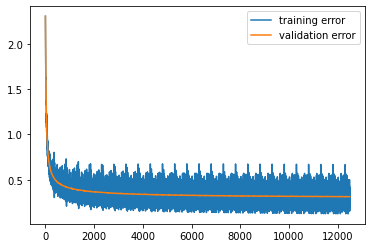

In [37]:
weights, losses, losses_val = SGD(X, y, x_val, y_val, n_epochs = 25,
                                  batch_size = 100, l2_reg = .0)

plt.plot(losses, label = 'training error')
plt.plot(losses_val, label = 'validation error')
plt.legend()

preds = predict(weights, x_test)
preds_test_set = np.argmax(preds, axis = 1)
accuracy_test_set = np.mean(preds_test_set == np.nonzero(y_test)[1])
print("Test accuracy: {:}".format(accuracy_test_set))


Test accuracy: 0.7881


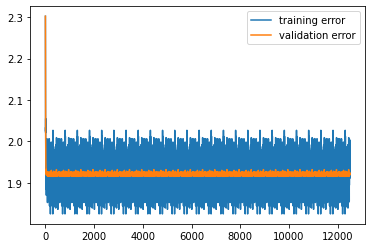

In [38]:
weights, losses, losses_val = SGD(X, y, x_val, y_val, n_epochs = 25,
                                  batch_size = 100, l2_reg = 1.0)

plt.plot(losses, label = 'training error')
plt.plot(losses_val, label = 'validation error')
plt.legend()

preds = predict(weights, x_test)
preds_test_set = np.argmax(preds, axis = 1)
accuracy_test_set = np.mean(preds_test_set == np.nonzero(y_test)[1])
print("Test accuracy: {:}".format(accuracy_test_set))


Test accuracy: 0.91


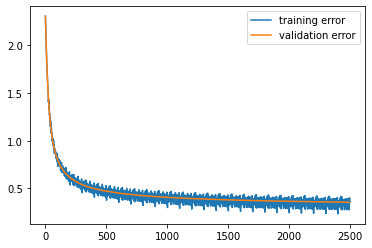

In [26]:
weights, losses, losses_val = SGD(X, y, x_val, y_val, n_epochs = 25,
                                  batch_size = 500, l2_reg = 0.)

plt.plot(losses, label = 'training error')
plt.plot(losses_val, label = 'validation error')
plt.legend()

preds = predict(weights, x_test)
preds_test_set = np.argmax(preds, axis = 1)
accuracy_test_set = np.mean(preds_test_set == np.nonzero(y_test)[1])
print("Test accuracy: {:}".format(accuracy_test_set))


Test accuracy: 0.8469


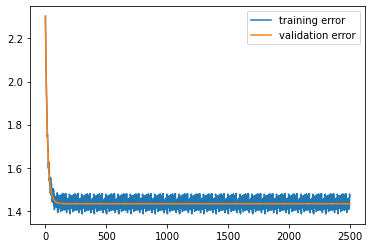

In [27]:
weights, losses, losses_val = SGD(X, y, x_val, y_val, n_epochs = 25,
                                  batch_size = 500, l2_reg = 0.25)

plt.plot(losses, label = 'training error')
plt.plot(losses_val, label = 'validation error')
plt.legend()

preds = predict(weights, x_test)
preds_test_set = np.argmax(preds, axis = 1)
accuracy_test_set = np.mean(preds_test_set == np.nonzero(y_test)[1])
print("Test accuracy: {:}".format(accuracy_test_set))


Test accuracy: 0.8581


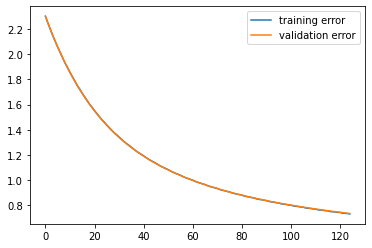

In [29]:
weights, losses, losses_val = SGD(X, y, x_val, y_val, n_epochs = 25,
                                  batch_size = 10000, l2_reg = 0.)

plt.plot(losses, label = 'training error')
plt.plot(losses_val, label = 'validation error')
plt.legend()

preds = predict(weights, x_test)
preds_test_set = np.argmax(preds, axis = 1)
accuracy_test_set = np.mean(preds_test_set == np.nonzero(y_test)[1])
print("Test accuracy: {:}".format(accuracy_test_set))


Test accuracy: 0.9215


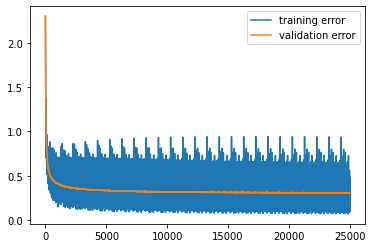

In [40]:
weights, losses, losses_val = SGD(X, y, x_val, y_val, n_epochs = 25,
                                  batch_size = 50, l2_reg = 0.)

plt.plot(losses, label = 'training error')
plt.plot(losses_val, label = 'validation error')
plt.legend()

preds = predict(weights, x_test)
preds_test_set = np.argmax(preds, axis = 1)
accuracy_test_set = np.mean(preds_test_set == np.nonzero(y_test)[1])
print("Test accuracy: {:}".format(accuracy_test_set))
